# [E-16] Next Movie Prediction
"Exploration Node 16. Predict the movie coming next" / 2022. 03. 15 (Tue) 이형주

## Contents
---
- **1. Environment Setup**
- **2. Modeling**
- **3. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

## 1. Environment Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from dateutil import tz
from pathlib import Path
import os
import random

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


**데이터 전처리**

In [3]:
# 한 user id당 몇 개의 데이터를 갖고 있는지 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
# 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행
# 1. Session length
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
session_length.min(), session_length.max()

(20, 2314)

In [6]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:
# quantile: 구간을 보여주는 개념 (parameter 0.999 -> 99.9% session)
session_length.quantile(0.999)

1343.181000000005

In [8]:
# visualization
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

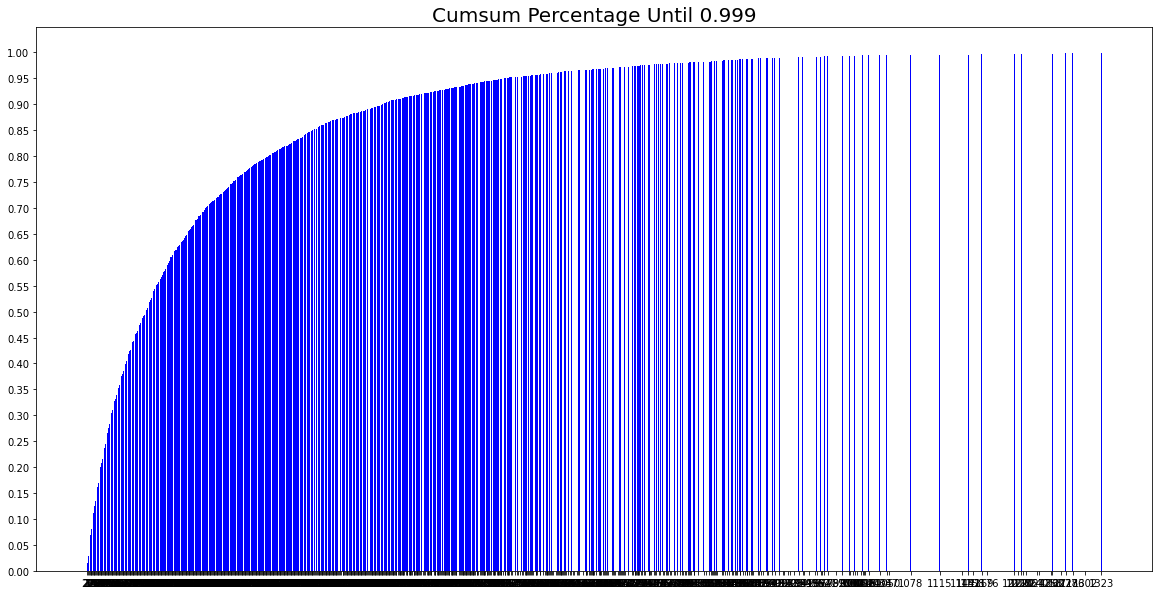

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [10]:
# 2. datetime
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
oldest, latest

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

<AxesSubplot:xlabel='Rating', ylabel='Density'>

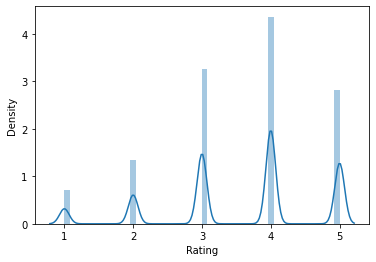

In [12]:
sns.distplot(data['Rating'])

In [13]:
rate = data[data['Rating']>=3]
rate

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [14]:
data[data['Rating']>=3]

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [15]:
data = data[data['Rating']>=3]
len(data)

836478

In [16]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있음
# 3. Cleansing
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


**Mini Batch**

In [18]:
# Training, Valid, Test Set 정의
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
#     after_date = after_date[after_date['UserId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [19]:
# 34개월에 대한 데이터를 3개월 단위로 세팅
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [20]:
# data에 대한 정보
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 828507
	 Sessions: 6037
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 3537
	 Sessions: 228
	 Items: 1540
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 3745
	 Sessions: 230
	 Items: 1558
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. Modeling

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [26]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 828112, 828231, 828507], dtype=int32)

In [27]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6034, 6035, 6036])

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=32):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=5)

In [36]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [37]:
tr['UserId'].nunique()

6037

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total= total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
# 모델 트레이닝 진행
train_model(model, args)

Evaluation:  16%|█▌        | 4/25 [00:01<00:08,  2.51it/s]


	 - Recall@5 epoch 1: 0.023438
	 - MRR@5    epoch 1: 0.014551



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.43it/s]


	 - Recall@5 epoch 2: 0.023438
	 - MRR@5    epoch 2: 0.011979



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.30it/s]


	 - Recall@5 epoch 3: 0.021484
	 - MRR@5    epoch 3: 0.012012



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.48it/s]


	 - Recall@5 epoch 4: 0.033203
	 - MRR@5    epoch 4: 0.016569



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.42it/s]


	 - Recall@5 epoch 5: 0.037109
	 - MRR@5    epoch 5: 0.018815



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.46it/s]


	 - Recall@5 epoch 6: 0.035156
	 - MRR@5    epoch 6: 0.018750



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.47it/s]


	 - Recall@5 epoch 7: 0.035156
	 - MRR@5    epoch 7: 0.018848



Evaluation:  16%|█▌        | 4/25 [00:01<00:05,  3.60it/s]


	 - Recall@5 epoch 8: 0.033203
	 - MRR@5    epoch 8: 0.018685



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.47it/s]


	 - Recall@5 epoch 9: 0.037109
	 - MRR@5    epoch 9: 0.019727



Evaluation:  16%|█▌        | 4/25 [00:01<00:05,  3.56it/s]

	 - Recall@5 epoch 10: 0.039062
	 - MRR@5    epoch 10: 0.021484



In [41]:
#### 모델 평가
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  15%|█▍        | 4/27 [00:02<00:15,  1.49it/s]

	 - Recall@5: 0.179688
	 - MRR@5: 0.058122



In [46]:
# 하이퍼파라미터 수정
# drop_rate => 0.1 -> 0.2
# epochs => 10 -> 5
# batch_size => 128 -> 256

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=5)

In [47]:
# 모델 재정의
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    503850    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [48]:
# 모델 트레이닝 진행
train_model(model, args)

Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]


IndexError: index 228 is out of bounds for axis 0 with size 228

In [49]:
# IndexError 발생, 하이퍼파라미터 수정
# batch_size 축소 => 256 -> 128
# hsz => 50 -> 70

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=70, drop_rate=0.2, lr=0.001, epochs=5, k=5)

In [50]:
# 모델 재정의
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 70), (128, 70)]    709590    
_________________________________________________________________
dropout_2 (Dropout)          (128, 70)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3307)               234797    
Total params: 944,387
Trainable params: 944,387
Non-trainable params: 0
_________________________________________________________________


In [51]:
# 모델 트레이닝 진행
train_model(model, args)

Evaluation:  16%|█▌        | 4/25 [00:01<00:08,  2.42it/s]


	 - Recall@5 epoch 1: 0.025391
	 - MRR@5    epoch 1: 0.013411



Evaluation:  16%|█▌        | 4/25 [00:01<00:05,  3.60it/s]


	 - Recall@5 epoch 2: 0.037109
	 - MRR@5    epoch 2: 0.017285



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.40it/s]


	 - Recall@5 epoch 3: 0.035156
	 - MRR@5    epoch 3: 0.021875



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.16it/s]


	 - Recall@5 epoch 4: 0.033203
	 - MRR@5    epoch 4: 0.020573



Evaluation:  16%|█▌        | 4/25 [00:01<00:06,  3.20it/s]

	 - Recall@5 epoch 5: 0.037109
	 - MRR@5    epoch 5: 0.019596



In [52]:
#### 모델 평가
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  15%|█▍        | 4/27 [00:02<00:15,  1.50it/s]

	 - Recall@5: 0.119141
	 - MRR@5: 0.045055



## 3. Project Retrospective

+ 하이퍼파라미터, 세션 재정의 등을 통한 Recall, MRR 수치 변화를 관찰하였다.

    batch_size=128, hsz=70, drop_rate=0.2, lr=0.001, epochs=5, k=5
    - Recall@5: 0.119141
	 - MRR@5: 0.045055

    batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=5
	 - Recall@5: 0.179688
	 - MRR@5: 0.058122
     
     
+ USER ID 기준으로 전처리를 진행했고, hsz와 drop_rate 조정시 하이퍼파라미터 수가 크게 증가하였다.
+ 전체적으로 크게 어렵지는 않았으나 추후에 있을 NLP에서 라이브러리 버전관리를 어떻게 진행할지에 대해 고민이 될 듯 하다.